# Starting glider data analysis

In [1]:
import utils

### 1. Get a list of datasets of interest

One can make of glider-mission combinations by examining maps and figures from the [observations portal](https://observations.voiceoftheocean.org/), which can then be matched to dataset IDs (see [glider_data_download notebook](https://github.com/voto-ocean-knowledge/download_glider_data/blob/main/glider_data_download.ipynb) in this repo). Alternatively, one can programatically interogate the ERDDAP itself to find datasets that match certain criteria ([metatadata_dig notebook in this repo](https://github.com/voto-ocean-knowledge/download_glider_data/blob/main/metadata_dig.ipynb)).

Either way, you end up with a list of datasetIDs like this:



In [2]:
datasets_to_download = ['delayed_SEA068_M27', 'nrt_SEA068_M27', 'delayed_SEA069_M9',
       'nrt_SEA069_M9', 'delayed_SEA067_M26', 'nrt_SEA067_M26',
       'delayed_SEA067_M27', 'nrt_SEA067_M27', 'delayed_SEA067_M29',
       'nrt_SEA067_M29', 'nrt_SEA067_M30', 'delayed_SEA066_M41',
       'nrt_SEA066_M41', 'nrt_SEA066_M42']

These are datasets that extended to > 150 m depth in the seas northeast of Gotland

### 2. Quick check with nrt datasets

For preliminary analysis, I recommend downloading only the NRT (near real time) datasets, as these are ~ 100 times smaller than the delayed mode data and are much quicker to work with. To achieve this, we use the `nrt_only=True` kwarg

In [3]:
ds_dict = utils.download_glider_dataset(datasets_to_download, nrt_only=True)

delayed_SEA068_M27 is not nrt. Ignoring
delayed_SEA069_M9 is not nrt. Ignoring
delayed_SEA067_M26 is not nrt. Ignoring
delayed_SEA067_M27 is not nrt. Ignoring
delayed_SEA067_M29 is not nrt. Ignoring
delayed_SEA066_M41 is not nrt. Ignoring


This function returns a dictionary where the keys are dataset IDs and the values are the datasets as xarray objects

In [4]:
ds_dict["nrt_SEA068_M27"]

<xarray.Dataset>
Dimensions:                (timeseries: 73, obs: 4052)
Coordinates:
    latitude               (obs) float64 ...
    longitude              (obs) float64 ...
    time                   (obs) datetime64[ns] ...
    depth                  (obs) float64 ...
Dimensions without coordinates: timeseries, obs
Data variables: (12/36)
    profile_index          (timeseries) float64 ...
    rowSize                (timeseries) int32 ...
    angular_cmd            (obs) float64 ...
    angular_pos            (obs) float64 ...
    backscatter            (obs) float64 ...
    backscatter_raw        (obs) float64 ...
    ...                     ...
    voltage                (obs) float64 ...
    distance_over_ground   (obs) float64 ...
    profile_direction      (obs) float64 ...
    potential_density      (obs) float64 ...
    density                (obs) float64 ...
    potential_temperature  (obs) float64 ...
Attributes: (12/72)
    acknowledgement:               This study used data collected and made fr...
    basin:                         Eastern Gotland Basin
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    comment:                       deployment and recovery in Skagerrak
    contributor_name:              Callum Rollo, Louise Biddle, Olle Petersso...
    ...                            ...
    time_coverage_end:             2022-07-31T02:47:09Z
    time_coverage_start:           2022-07-27T17:09:41Z
    title:                         Aster68-20220727T1709
    transmission_system:           IRIDIUM
    Westernmost_Easting:           19.901883333333334
    wmo_id:                        6801602

### 3. Initial analysis

Here we will create some quick plots to check that the datasets have what we need

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('presentation.mplstyle')
import cartopy
import cartopy.crs as ccrs

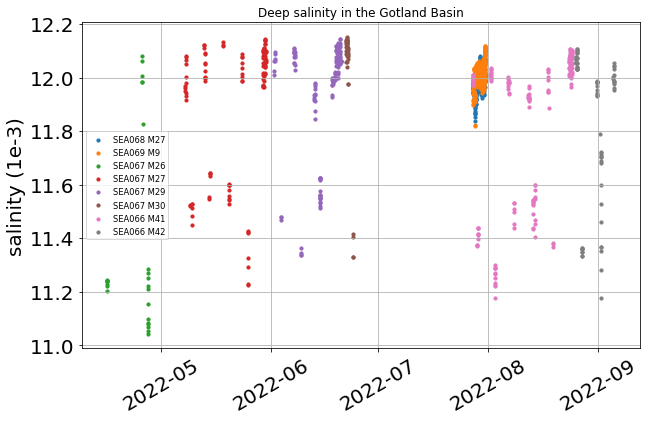

In [6]:
min_depth = 140
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.time[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()

A small map of the area

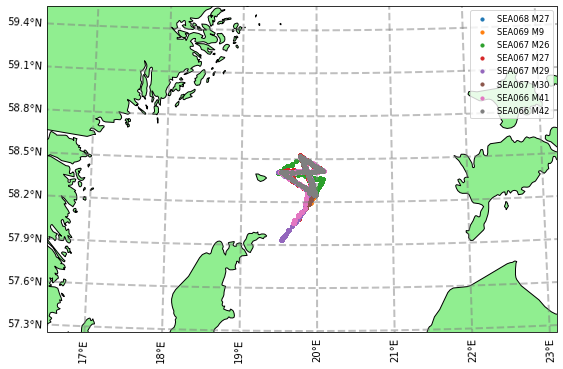

In [7]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean(ds.longitude.values),
                                  central_latitude=np.mean(ds.latitude.values))
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)

for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.longitude.values, ds.latitude.values, transform=pc, s=10, label=pretty_label)
lon_extend = 3
lat_extend = 1
lims = (np.nanmin(ds.longitude.values) - lon_extend, np.nanmax(ds.longitude.values) + lon_extend,
        np.nanmin(ds.latitude.values) - lat_extend, np.nanmax(ds.latitude.values) + lat_extend)
ax.set_extent(lims, crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                       scale='10m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None
ax.legend()

Maybe there's a geographical gradient at play too? There appears to be a bimodal distribution of salinity. Rather than a timeseries, let's plot against latitude

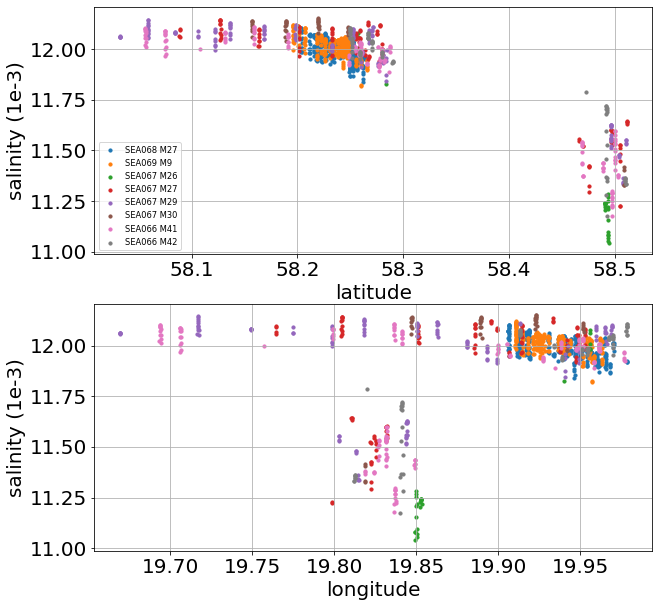

In [8]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10, 10))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax0.scatter(ds.latitude[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
    ax1.scatter(ds.longitude[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax0.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax0.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", xlabel="latitude")
ax1.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", xlabel="longitude")
ax0.grid()
ax1.grid()

There's definitely some spatial vartiability here. Maybe a seperare sub-basin to the southeast? Let's subset our data a bit before plotting it

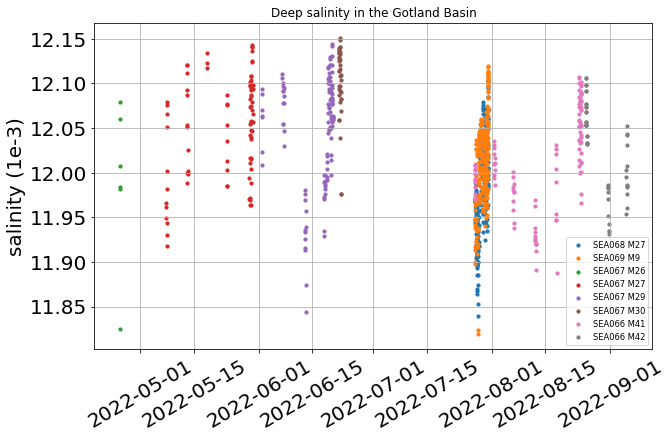

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    mask = (ds.depth.values > min_depth) * (ds.latitude.values<58.4)
    ax.scatter(ds.time[mask], ds.salinity[mask], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()

### 4. Download the full datasets

Once we are confident that the dataset contain something of interest, we can download the full size delayed mode datasets. This uses a cache of data in the directory `voto_erddap_data_cache` to avoid duplicate downloads. **To force data to re-download, simply delete the cache dir**

In [10]:
ds_delayed = utils.download_glider_dataset(datasets_to_download, delayed_only=True)

nrt_SEA068_M27 is not delayed. Ignoring
nrt_SEA069_M9 is not delayed. Ignoring
nrt_SEA067_M26 is not delayed. Ignoring
nrt_SEA067_M27 is not delayed. Ignoring
nrt_SEA067_M29 is not delayed. Ignoring
nrt_SEA067_M30 is not delayed. Ignoring
nrt_SEA066_M41 is not delayed. Ignoring
nrt_SEA066_M42 is not delayed. Ignoring
Writing voto_erddap_data_cache/delayed_SEA068_M27.nc
Writing voto_erddap_data_cache/delayed_SEA069_M9.nc
Found voto_erddap_data_cache/delayed_SEA067_M26.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M27.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M29.nc. Loading from disk
Writing voto_erddap_data_cache/delayed_SEA066_M41.nc


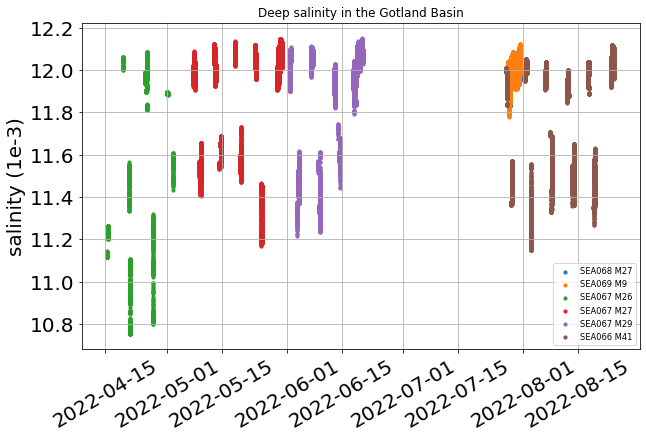

In [11]:
min_depth = 140
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_delayed.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.time[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()